# Aprendizagem Automática - Assignment 1 

In [62]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models and selection methods
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, train_test_split

# Binary classifier metrics
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Linear regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr

Importação do dataset parkinsons

In [63]:
parkinsons_data = pd.read_csv("parkinsons_updrs.data")
parkinsons_data

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


## Objective 1
Preparação do dataset

In [64]:
# Copiar o dataframe original
parkinsons_objective1 = parkinsons_data.copy()

# Remover a coluna total_UPDRS e subject#
parkinsons_objective1.drop(columns=["subject#","total_UPDRS"], inplace=True)

# Divisão do dataset em variaveis independentes e dependentes
X_obj1 = parkinsons_objective1[set(parkinsons_objective1.columns) - {"motor_UPDRS"}]
y_obj1 = parkinsons_objective1["motor_UPDRS"]

# Converter para np array
Xc_obj1 = X_obj1.to_numpy()
yc_obj1 = y_obj1.to_numpy()

# Divisão do dataset em training set e independent validation set
X_obj1_TRAIN, X_obj1_IVS, y_obj1_TRAIN, y_obj1_IVS = train_test_split(Xc_obj1, yc_obj1, test_size=0.10, random_state=314)

C:\Users\jpnev\AppData\Local\Temp\ipykernel_12312\3560822554.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_obj1 = parkinsons_objective1[set(parkinsons_objective1.columns) - {"motor_UPDRS"}]


### Fitting e validação dos modelos

N-Fold split

In [65]:
kf1 = KFold(n_splits=100, shuffle=True, random_state = 274)
kf1.get_n_splits(X_obj1_TRAIN)

100

##### Decision Tree Regressor

N-Cross validation

In [66]:
# NOTA: é preciso fazer isto para diferentes hyperparameters e guardar
#       as metricas para cada um, assim podemos comparar depois e determinar
#       qual os melhores hyperparameters antes de validarmos o modelo com os
#       dados IVS. Depois de fazermos isto para o decision tree regressor, temos
#       de o fazer para o linear regressor que vamos dar na aula de amanha

In [67]:
TRUTH=None
PREDS=None

for train_index, test_index in kf1.split(X_obj1_TRAIN):
    X_train, X_test = X_obj1_TRAIN[train_index], X_obj1_TRAIN[test_index]
    y_train, y_test = y_obj1_TRAIN[train_index], y_obj1_TRAIN[test_index]
    dtr_obj1 = DecisionTreeRegressor()
    dtr_obj1.fit(X_train, y_train)
    preds = dtr_obj1.predict(X_test)
    if TRUTH is None:
        PREDS=preds
        TRUTH=y_test
    else:
        PREDS=np.hstack((PREDS, preds))
        TRUTH=np.hstack((TRUTH, y_test))

In [68]:
print("The RVE is: ", explained_variance_score(TRUTH, PREDS))
print("The rmse is: ", mean_squared_error(TRUTH, PREDS, squared=False))
corr, pval=pearsonr(TRUTH, PREDS)
print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))

print("The Maximum Error is is: ", max_error(TRUTH, PREDS))
print("The Mean Absolute Error is: ", mean_absolute_error(TRUTH, PREDS))

The RVE is:  0.9163030071269886
The rmse is:  2.3538198947363074
The Correlation Score is is: 0.9581 (p-value=0.000000e+00)

The Maximum Error is is:  26.707
The Mean Absolute Error is:  0.6908789105352753


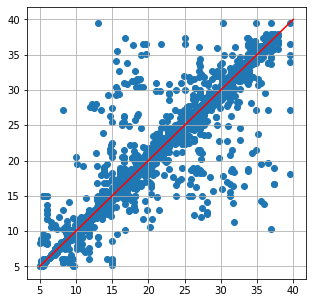

In [69]:
plt.figure(figsize=(5,5))
plt.scatter(PREDS, TRUTH)
plt.plot((5, 40), (5,40), c="r")
plt.grid()
plt.show()

## Objective 2
Preparação do dataset

In [76]:
# Copiar o dataframe original
parkinsons_objective2 = parkinsons_data.copy()
# Remover a coluna subject# e motor_UPDRS
parkinsons_objective2.drop(columns=["subject#","motor_UPDRS"], inplace=True)
# Transformação de total_UPDRS em variavel binaria
parkinsons_objective2["total_UPDRS"] = parkinsons_objective2["total_UPDRS"].apply(lambda x : 1 if x > 40 else 0)

X_obj2 = parkinsons_objective2[set(parkinsons_objective2.columns) - {"total_UPDRS"}]
y_obj2 = parkinsons_objective2["total_UPDRS"]

# Converter para np array
Xc_obj2 = X_obj2.to_numpy()
yc_obj2 = y_obj2.to_numpy()

# Divisprint(y_obj2)ão do dataset em training set e independent validation set
X_obj2_TRAIN, X_obj2_IVS, y_obj2_TRAIN, y_obj2_IVS = train_test_split(Xc_obj2, yc_obj2, test_size=0.10, random_state=314)

C:\Users\jpnev\AppData\Local\Temp\ipykernel_12312\3962844160.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_obj2 = parkinsons_objective2[set(parkinsons_objective2.columns) - {"total_UPDRS"}]


### Fitting e validação dos modelos

N-Fold Split

In [71]:
kf2 = KFold(n_splits=100, shuffle=True, random_state = 274)
kf2.get_n_splits(X_obj2_TRAIN)

100

##### Decision Tree Classifier

N-Cross validation

In [38]:
# NOTA: é preciso fazer isto para diferentes hyperparameters e guardar
#       as metricas para cada um, assim podemos comparar depois e determinar
#       qual os melhores hyperparameters antes de validarmos o modelo com os
#       dados IVS. 
#       Para além disto, devemos testar tanto com um critério de entropia,
#       bem como de Gini.

# Exemplos: min_samples_leaf, max_depth...

In [77]:
TRUTH=None
PREDS=None

for train_index, test_index in kf1.split(X_obj1_TRAIN):
    X_train, X_test = X_obj2_TRAIN[train_index], X_obj2_TRAIN[test_index]
    y_train, y_test = y_obj2_TRAIN[train_index], y_obj2_TRAIN[test_index]
    
    dtr_obj2 = DecisionTreeClassifier(max_depth=3)
    dtr_obj2.fit(X_train, y_train)
    
    preds = dtr_obj2.predict(X_test)
    if TRUTH is None:
        PREDS=preds
        TRUTH=y_test
    else:
        PREDS=np.hstack((PREDS, preds))
        TRUTH=np.hstack((TRUTH, y_test))

In [86]:
print("The RVE is: ", explained_variance_score(TRUTH, PREDS))
print("The rmse is: ", mean_squared_error(TRUTH, PREDS, squared=False))
corr, pval=pearsonr(TRUTH, PREDS)
print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
print("The Maximum Error is is: ", max_error(TRUTH, PREDS))
print("The Mean Absolute Error is: ", mean_absolute_error(TRUTH, PREDS))

print("################")
print()

print("These are the training set statistics:")
print("The Precision is: %7.4f" % precision_score(TRUTH, PREDS))
print("The Recall is: %7.4f" % recall_score(TRUTH, PREDS))
print("The F1 score is: %7.4f" % f1_score(TRUTH, PREDS))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(TRUTH, PREDS))

The RVE is:  0.1281619871823917
The rmse is:  0.3731077344438156
The Correlation Score is is: 0.3963 (p-value=2.454986e-198)

The Maximum Error is is:  1
The Mean Absolute Error is:  0.13920938150179685
################

These are the training set statistics:
The Precision is:  0.8379
The Recall is:  0.2337
The F1 score is:  0.3655
The Matthews correlation coefficient is:  0.3963
